# Exercise 2

Work on this before the next lecture on 12 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to your GitHub repository for this course before the next lecture starts and post a link to your repository in [this thread](https://github.com/wildtreetech/advanced-computing-2018/issues/3). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

# Question 1

Build your own random forest classifier! Using the `DecisionTreeClassifier` from scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) construct your own `RandomForestClassifier`.

There are two methods for adding randomisation to the tree growing process:

* grow each tree on a bootstrap sample of the data
* configure each tree to select a subset of features for each split

Try out your new `RandomForestClassifier` on the https://archive.ics.uci.edu/ml/datasets/bank+marketing dataset.

**Note:** To test your classifier it is a good idea to use a smaller dataset like the `make_blobs` from the lecture. It will run much faster and be easier to debug.

* Can you show that a forest of trees that are all the same performs like a single decision tree?
* Can you compute the correlation coefficient between scores assigned by two different trees in the forest? In order to gain from buildign a forest you want your trees to not be 100% correlated. Experiment with the different randomisation strategies to check that they work.

In [2]:
# your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import csv


#### Functions used for the exercise

def bootstrap(X, y, ratio):
    X_keep, X_loss, y_keep, y_loss = train_test_split(X, y, train_size=ratio, test_size=1.-ratio)
    ind = np.random.randint(y_keep.shape[0], size=(y_loss.shape[0],))
    np.append(X_keep, X_keep[ind,:])
    np.append(y_keep, y_keep[ind])
    return X_keep, y_keep, None

def subset(X, y, ratio):
    nber_features = int(X.shape[1] * ratio)
    ind = np.random.randint(X.shape[1], size=(nber_features,))
    return X[:,ind], y, ind

def RandomForestClassifier(X,y,n_estimator,random,same):
    '''random is the method used to select the datasets -- same indicate if the sets are the same'''
    ratio=1./n_estimator
    trees=[]
    list_ind=[]
    if same:
        x_tree,y_tree,ind=random(X,y,ratio)
    for i in range(n_estimator):
        if not same:
            x_tree, y_tree, ind = random(X, y, ratio)
        dtc = DecisionTreeClassifier()
        dtc.fit(x_tree, y_tree)
        trees.append(dtc)
        list_ind.append(ind)
    return trees, list_ind

def PredictForest(trees, X):
    list_ind = trees[1]
    trees = trees[0]
    sol = None
    for i in range(len(trees)):
        tree = trees[i]
        ind = list_ind[i]
        if ind is None:
            tmp = tree.predict(X)
        else:
            tmp = tree.predict(X[:,ind])
        if sol is None:
            sol = tmp
        else:
            sol += tmp
    sol = sol / len(trees)
    return sol

def CorrelateForest(trees, X):
    list_ind = trees[1]
    trees = trees[0]
    predictions = []
    # predict
    for i in range(len(trees)):
        tree = trees[i]
        ind = list_ind[i]
        if ind is None:
            tmp = tree.predict(X)
        else:
            tmp = tree.predict(X[:,ind])
        std = np.std(tmp)
        if std == 0:
            std = 1
        tmp = (tmp - np.mean(tmp)) / std
        predictions.append(tmp)
    # correlate
    corr = []
    for pred_a in predictions:
        corr_tmp = []
        for pred_b in predictions:
            if pred_b is pred_a:
                continue
            # normalize pred_a
            pred_a /= len(pred_a)
            tmp = np.correlate(pred_a, pred_b)[0]
            corr_tmp.append(tmp)
        corr.append(corr_tmp)     
    return np.array(corr)


#### Test on the blobs
labels = [15, 30]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))
'''
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, lw=0, s=20)
plt.title('Full sample with color labels')
plt.show()
'''

#### Working on the bank datasets
filename = './bank/bank-full.csv'
dtype = (object, 16)
X = np.genfromtxt(filename, delimiter=";", skip_header=1, dtype=dtype,usecols=range(16))
todo = [1, 2, 3, 4, 6, 7, 8, 10, 15]
for i in todo:
    le = LabelEncoder().fit(X[:,i])
    X[:,i] = le.transform(X[:,i])
y = np.genfromtxt(filename, delimiter=";", skip_header=1, dtype=None,usecols=[16])
le = LabelEncoder().fit(y)
y = le.transform(y)
y = y[:,np.newaxis]


r_train = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r_train, test_size=1.-r_train)


#### Fit data
random_method = bootstrap
n_estimator = 10
same = False
trees = RandomForestClassifier(X_train, y_train, n_estimator, random_method, same)
y_sol = PredictForest(trees, X_test)

#### Fit data single tree
single = [trees[0],]
y_single = PredictForest(trees, X_test)


#### Plot data
diff = np.sum((y_sol-y_single)**2)
print("Difference between single tree and forest of same trees", diff)
'''
plt.figure()
#plt.title(title)
plt.scatter(X[:,0], X[:,1], s=y)
plt.show()
'''

#### Correlate scores
random_method = bootstrap
n_estimator = 5
same = False
trees = RandomForestClassifier(X_train, y_train, n_estimator, random_method, same)
corr = CorrelateForest(trees, X_test)

boot_corr = corr.mean()

random_method = subset
trees = RandomForestClassifier(X_train, y_train, n_estimator, random_method, same)
corr = CorrelateForest(trees, X_test)

subset_corr = corr.mean()
print('\nMean correlation in bootsrap %g and in subset %g' % (boot_corr, subset_corr))
print('\n \nBootstrap is more useful than the subset as the requirements on the data are weaker.')
print('However the subset is more efficient at decorrelating the data.')

Difference between single tree and forest of same trees 0.0

Mean correlation in bootsrap 0.0184767 and in subset -0.000152073

 
Bootstrap is more useful than the subset as the requirements on the data are weaker.
However the subset is more efficient at decorrelating the data.


# Question 2

Use the ready made `RandomForestClassifier` from scikit-learn to create the best model you can for the Bank Marketing dataset. Use `GridSearchCV` (or any other method) to tune your model and possible pre-processing steps. Make sure you have a test set to use after you are done tuning to estimate your generalisation error.

In [3]:
# your code here
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# create data
filename = './bank/bank.csv'
dtype = (object, 16)
X = np.genfromtxt(filename, delimiter=";", skip_header=1, dtype=dtype, usecols=range(16))
todo = [1, 2, 3, 4, 6, 7, 8, 10, 15]
for i in todo:
    le = LabelEncoder().fit(X[:,i])
    X[:,i] = le.transform(X[:,i])
y = np.genfromtxt(filename, delimiter=";", skip_header=1, dtype=None, usecols=[16])
le = LabelEncoder().fit(y)
y = le.transform(y)

r_train = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r_train, test_size=1.-r_train)

fields = {'n_estimators': [5, 10, 20, 50, 100],'max_depth': [5, 10, 20, 50, 100],
          'min_impurity_decrease': [0.01, 0.05, 0.1, 0.2],'bootstrap': [True, False]}

rfc = RandomForestClassifier()

gscv = GridSearchCV(rfc, param_grid=fields)
    
gscv.fit(X_train, y_train)
rfc = gscv.best_estimator_

print(rfc.score(X_test, y_test))



0.877348066298


# Question 3

Compare the feature importances calculated by a `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostedTreesClassifier` on the california housing dataset. You might have to tune `n_estimators` and other hyper-parameters to get good performance.

Plot each of the features as a scatter plot with the target to learn about each variable. You can also make a plot of two features and use the target as colour.

Fit a model and tune the model complexity using a training and test data set.

Explore the feature importances and partial dependences that are important to the house price.

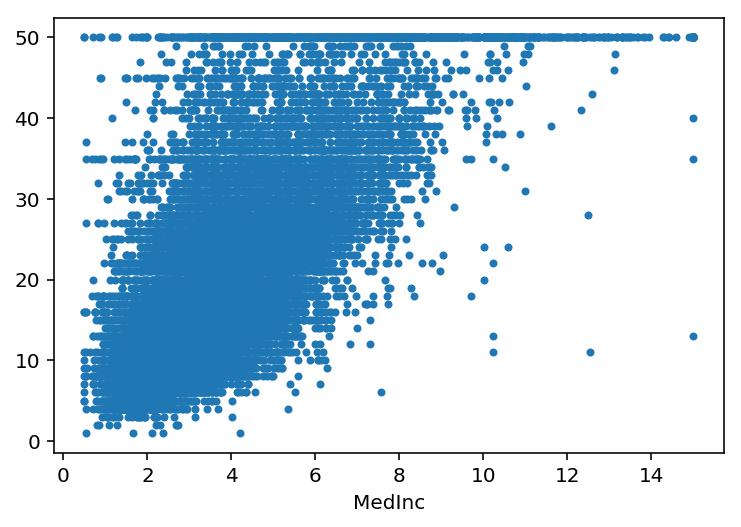

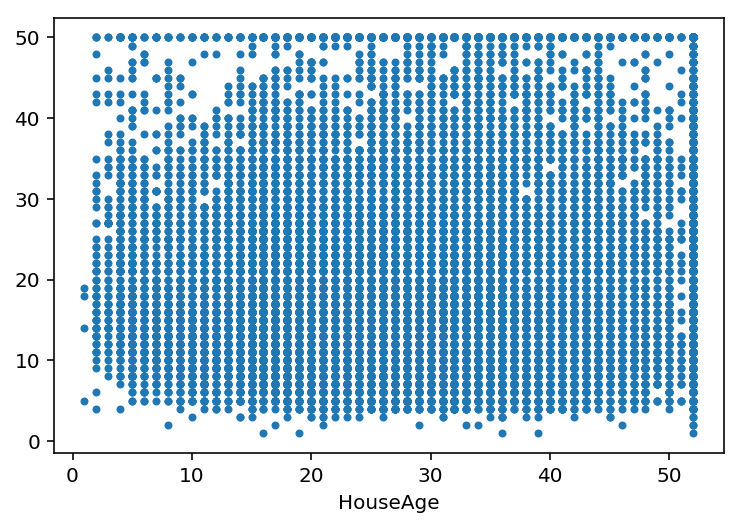

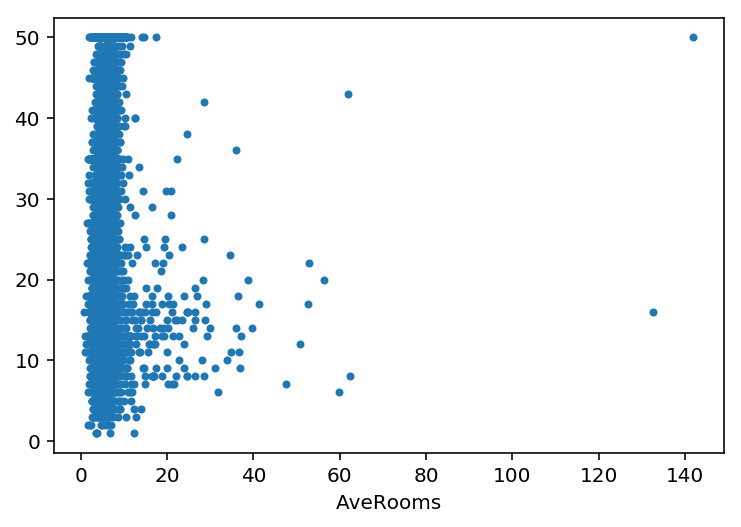

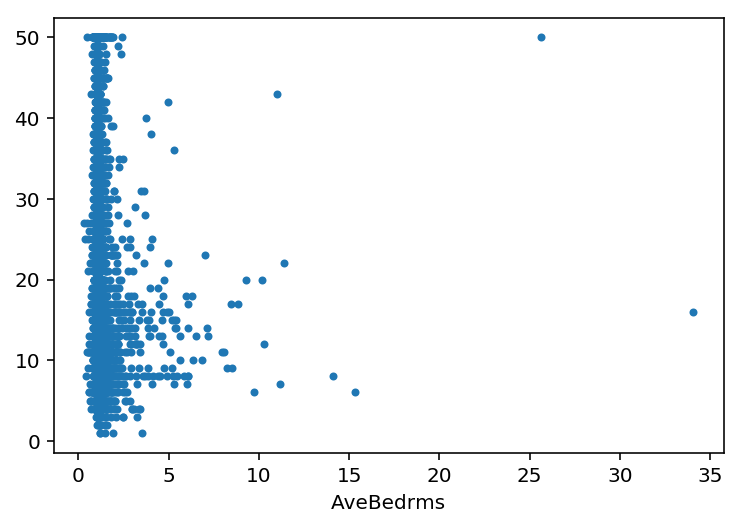

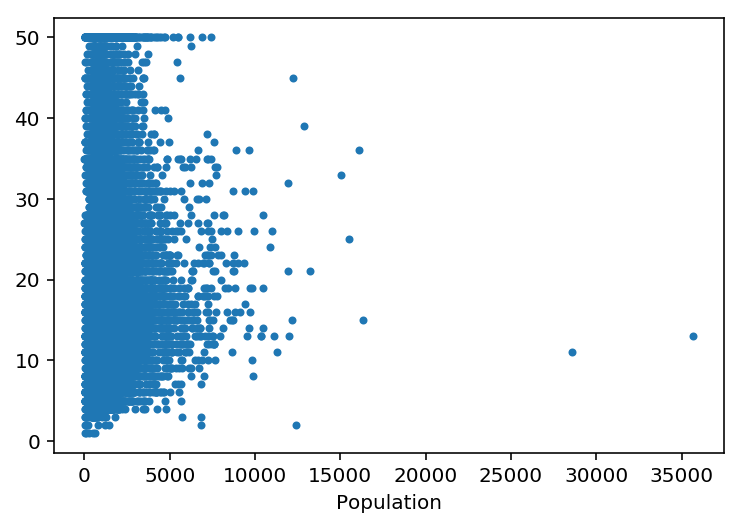

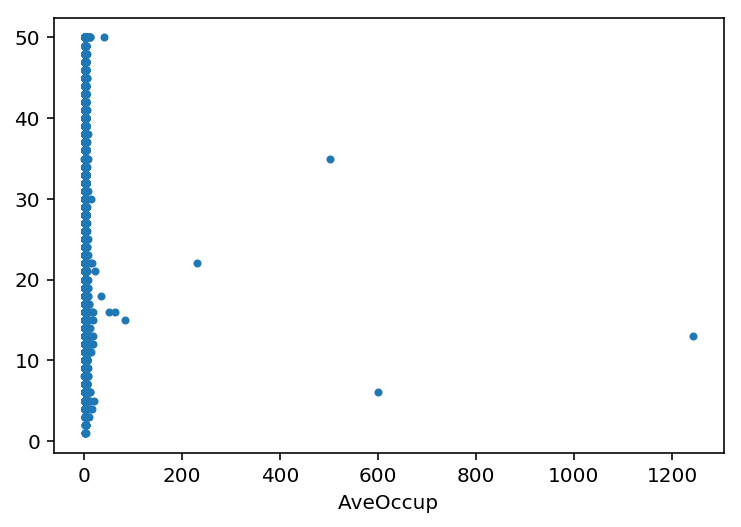

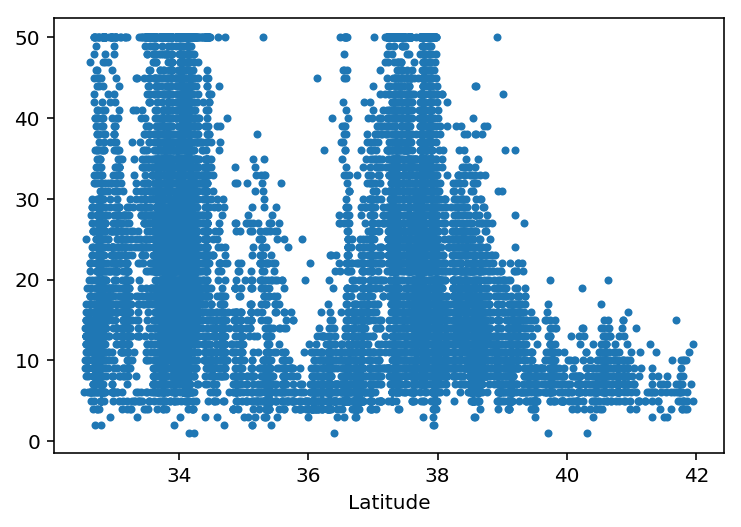

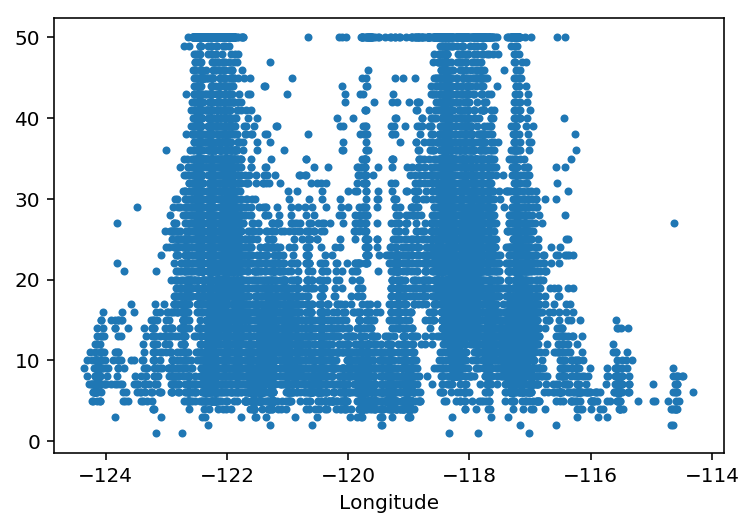

The best number of estimators found are 140 (RandomForest), 80 (ExtraTreesClassifier), 1 (GradientBoosting)
Fields: MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude
RandomForest: 0.151340109079 0.10275242732 0.125039773827 0.115968489633 0.116283768211 0.129542773264 0.127711562094 0.131361096572
ExtraTrees: 0.149117868792 0.104028661679 0.121706799892 0.113590266533 0.113692999406 0.126646691901 0.134043372956 0.137173338841
GradientBoosting: 0.491660258019 0.0317430634804 0.0396458182936 0.0310043060509 0.0540630862382 0.180266400606 0.0967709762612 0.0748460910507

 All the agorithms agree on that the most important field is Medinc and the less one is HouseAge. 
But the GradientBoosting is much more sensitive to the Medinc and much less to the HouseAge.


In [23]:
# your code here
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

cal_housing = fetch_california_housing()

# if the above doesn't work, download `cal_housing_py3.pkl` from the GitHub repository
# and adjust the path to the downloaded file which is passed to `load()`
# uncomment the following lines
#from sklearn.externals.joblib import load
#d = load('/home/username/Downloads/cal_housing_py3.pkz')
#X, y = d[:,1:], d[:,0]/100000
#X[:, 2] /= X[:, 5]
#X[:, 3] /= X[:, 5]
#X[:, 5] = X[:, 4] / X[:, 5]


def plot_data(X, y, feature):
    plt.figure()
    plt.plot(X, y, '.')
    plt.xlabel(feature)
    plt.show()

#### Get data
X = cal_housing['data']
y = (10 * cal_housing['target']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r_train, test_size=1.-r_train) #r_train = .8

#print(cal_housing['feature_names'])

#print(dir(cal_housing))
#print(cal_housing['DESCR'])

for i in range(X.shape[1]):
    plot_data(X[:,i],y, cal_housing['feature_names'][i])

'''
#### Find right n_estimators
rfc = RandomForestClassifier(n_jobs=8)
etc = ExtraTreesClassifier(n_jobs=8)
gbc = GradientBoostingClassifier()
estimators = [rfc, etc, gbc]
N = 10
n_estimators = np.linspace(20, 200, N).astype(int)

#### Plot results
plt.figure()
plt.title('Convergence number of estimators')
N = len(estimators)
for i in range(N):
    est = estimators[i]
    tmp = []
    for n in n_estimators:
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        score = est.score(X_test, y_test)
        tmp.append(score)
    plt.plot(n_estimators, tmp, label=type(est))
plt.legend()
plt.show()
'''

#rfc = RandomForestClassifier(n_estimators=200)
#etc - ExtraTreesClassifier(n_estimators)

print("The best number of estimators found are 140 (RandomForest), 80 (ExtraTreesClassifier), 1 (GradientBoosting)")
n_est = [140, 80, 1]

print("Fields:", *cal_housing["feature_names"])
cl = RandomForestClassifier(n_estimators=n_est[0])
cl.fit(X_train, y_train)
print("RandomForest:", *cl.feature_importances_)

cl = ExtraTreesClassifier(n_estimators=n_est[1])
cl.fit(X_train, y_train)
print("ExtraTrees:", *cl.feature_importances_)

cl = GradientBoostingClassifier(n_estimators=n_est[2])
cl.fit(X_train, y_train)
print("GradientBoosting:", *cl.feature_importances_)

print('\n','All the agorithms agree on that the most important field is Medinc and the less one is HouseAge.','\n'
     'But the GradientBoosting is much more sensitive to the Medinc and much less to the HouseAge.')



# Question 4

Competition time! Use any model you want (and understand) to make the best model you can to predict the target in the below dataset.

Each student's submission will be ranked by:
* their performance (using [AUC ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) as metric) and
* how well they did at predicting their generalisation error.

Your final rank will be the average of your two ranks.

To evaluate how good you did at predicting your generalisation error Tim will release a fresh test data set after the hand-in deadline. You can then re-run your trained classifier on that data and score its performance. We will rank students by the difference between that score and their predicted score.

You can read in the data using the `pandas` library. The final column of the file contains the target (zero or one).

In [15]:
import pandas as pd

# you might have to adjust the path to the dataset
df_train = pd.read_csv("challenge-train.csv", header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.000576,0.999939,12.769232,0.584357,0.136273,13.359463,3.358099,14655.587891,0.005370,0.041032,...,58935.695312,74241.648438,4598.116699,2.897916,2.932629,3.193417,267,-99,0.381424,0
1,0.001807,0.999996,18.585171,0.368892,0.054991,3.600483,6.781577,4145.290527,0.030382,0.034570,...,20553.839844,12501.964844,28162.607422,3.584545,3.010242,3.322494,128,1,0.781520,1
2,0.000858,0.999304,4.794842,0.149876,0.172385,16.130068,3.723242,4936.734375,0.017344,0.027622,...,7566.020020,11801.971680,16086.186523,2.700943,2.920070,2.407294,254,-99,0.508650,0
3,0.001519,0.999969,15.656528,0.312301,0.125831,8.113082,5.763765,4948.376465,0.035185,0.038973,...,19161.880859,18598.472656,17658.548828,3.108439,2.932674,3.164568,531,-99,0.682114,0
4,0.000936,0.999978,8.998086,0.475861,0.065347,3.863127,3.675261,4757.155762,0.022795,0.046165,...,12651.365234,33099.660156,10722.979492,2.873017,3.074762,4.136894,160,5,0.633693,1


In [ ]:
# convert the pandas dataframe to a numpy array
# make sure you do not include the final column
# in your training data (X) but store it as target (y)
X = df_train.as_matrix()[:, :-1]
y = df_train.as_matrix()[:, -1]

In [ ]:
X.shape

In [ ]:
y.shape

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# you might have to adjust the path to the dataset
ind = [i for i in range(49) if i != 46]
df_train = pd.read_csv("challenge-train.csv", header=None, usecols=ind)
df_train.head()
X = df_train.as_matrix()[:, :-1]
y = df_train.as_matrix()[:, -1]

r_train = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r_train, test_size=1.-r_train)

N = 1
d = {
    'learning_rate': np.linspace(0.01, 0.9, N),
    'max_depth': np.linspace(2, 15, N).astype(int),
    'min_samples_split': np.linspace(0.01, 1, N)
}

gbc = GradientBoostingClassifier()

gscv = GridSearchCV(gbc, param_grid=d)

gscv.fit(X_train, y_train)

gbc = gscv.best_estimator_

y_sol = gbc.predict(X_test)

print('AUC ROC score', roc_auc_score(y_test, y_sol))

print('I am expecting my score to be about 70 %.')

AUC ROC score 0.80814242022
I am expecting my score to be about 70 %.
